In [1]:
import pandas as pd

In [2]:
eco = pd.read_csv('Economy_Data.csv', sep=';')
private = pd.read_csv('PrivateSector_Data.csv', sep=';')
public = pd.read_csv('PublicSector_Indicators.csv', sep=';')
health = pd.read_csv('HealthAndPoverty_Data.csv', sep=';')
edu = pd.read_csv('EducationAndEnviron_Data.csv', sep=';')
x = pd.concat([eco, private, public, health, edu]).dropna()
x

,SeriesName,SeriesCode,CountryName,CountryCode,Year,Value
5,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,Brazil,BRA,1970.0,3.918974e+11
7,Adjusted net national income (constant 2010 US$),NY.ADJ.NNTY.KD,India,IND,1970.0,1.915335e+11
10,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,Brazil,BRA,1970.0,3.786021e+10
11,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,China,CHN,1970.0,8.525561e+10
12,Adjusted net national income (current US$),NY.ADJ.NNTY.CD,India,IND,1970.0,5.776720e+10
...,...,...,...,...,...,...
71480,Urban population growth (annual %),SP.URB.GROW,Brazil,BRA,2019.0,1.045678e+00
71481,Urban population growth (annual %),SP.URB.GROW,China,CHN,2019.0,2.292727e+00
71482,Urban population growth (annual %),SP.URB.GROW,India,IND,2019.0,2.305597e+00
71483,Urban population growth (annual %),SP.URB.GROW,Russian Federation,RUS,2019.0,1.344493e-01


In [3]:
x = x[:][x["CountryCode"]=="CHN"]

In [4]:
counts = x["SeriesName"].value_counts()
counts

Urban population                                                      50
Population ages 45-49, female (% of female population)                50
Population ages 30-34, female (% of female population)                50
Population ages 30-34, male (% of male population)                    50
Population ages 35-39, female (% of female population)                50
                                                                      ..
Firms with female participation in ownership (% of firms)              1
Firms visited or required meetings with tax officials (% of firms)     1
Firms using banks to finance working capital (% of firms)              1
Firms using banks to finance investment (% of firms)                   1
Plant species (higher), threatened                                     1
Name: SeriesName, Length: 1111, dtype: int64

In [5]:
aa = counts[:][counts>=50]

In [6]:
aa.shape

(126,)

In [10]:
x = x[:][x["SeriesName"].isin(list(aa.keys()))].drop_duplicates()

In [13]:
df_meas = x.pivot(index="Year", columns='SeriesName', values='Value')

In [25]:
nomes = list(df_meas.keys())
escolhidos = []
escolhidos_tmp = []

for nome in nomes:
    subnomes = "_".join(nome.split(" ")[0:2])
    if subnomes not in escolhidos_tmp:
        escolhidos_tmp.append(subnomes)
        escolhidos.append(nome)
escolhidos

['Age dependency ratio (% of working-age population)',
 'Agriculture, forestry, and fishing, value added (% of GDP)',
 'Arms exports (SIPRI trend indicator values)',
 'Arms imports (SIPRI trend indicator values)',
 'Exports of goods and services (% of GDP)',
 'External balance on goods and services (% of GDP)',
 'GDP (constant 2010 US$)',
 'GDP (current LCU)',
 'GDP growth (annual %)',
 'GDP per capita (constant 2010 US$)',
 'GNI (current LCU)',
 'GNI per capita (current LCU)',
 'GNI, Atlas method (current US$)',
 'Imports of goods and services (% of GDP)',
 'Industry (including construction), value added (% of GDP)',
 'Lower secondary school starting age (years)',
 'Merchandise exports (current US$)',
 'Merchandise imports (current US$)',
 'Merchandise trade (% of GDP)',
 'Mortality rate, infant (per 1,000 live births)',
 'Number of infant deaths',
 'Population ages 0-14 (% of total population)',
 'Population growth (annual %)',
 'Population in largest city',
 'Population, female',
 '

In [26]:
df_meas2 = df_meas[escolhidos]

In [31]:
df_meas2.corr()

SeriesName,Age dependency ratio (% of working-age population),"Agriculture, forestry, and fishing, value added (% of GDP)",Arms exports (SIPRI trend indicator values),Arms imports (SIPRI trend indicator values),Exports of goods and services (% of GDP),External balance on goods and services (% of GDP),GDP (constant 2010 US$),GDP (current LCU),GDP growth (annual %),GDP per capita (constant 2010 US$),...,"Population, female","Population, male","Population, total","Primary education, duration (years)",Primary school starting age (years),Rural population,"Secondary education, duration (years)","Services, value added (% of GDP)",Trade (% of GDP),Urban population
SeriesName,,,,,,,,,,,,,,,,,,,,,
Age dependency ratio (% of working-age population),1.000000,0.928025,-0.174035,-0.707931,-0.910642,-0.575499,-0.716252,-0.635679,-0.180956,-0.727618,...,-0.974857,-0.975151,-0.975014,-0.698895,0.698895,0.303732,-0.758960,-0.891398,-0.925002,-0.882589
"Agriculture, forestry, and fishing, value added (% of GDP)",0.928025,1.000000,-0.055530,-0.749164,-0.881128,-0.591940,-0.847402,-0.779900,-0.060200,-0.856029,...,-0.973942,-0.974718,-0.974347,-0.794569,0.794569,0.523736,-0.570813,-0.968533,-0.889862,-0.962799
Arms exports (SIPRI trend indicator values),-0.174035,-0.055530,1.000000,-0.309000,-0.069287,-0.248635,0.307325,0.340330,0.094586,0.304373,...,0.115462,0.115800,0.115637,0.206918,-0.206918,-0.303036,0.186304,0.171469,-0.040253,0.202663
Arms imports (SIPRI trend indicator values),-0.707931,-0.749164,-0.309000,1.000000,0.828469,0.592704,0.435505,0.344386,0.159301,0.446072,...,0.719459,0.719935,0.719708,0.510886,-0.510886,-0.173093,0.403933,0.672989,0.831366,0.632729
Exports of goods and services (% of GDP),-0.910642,-0.881128,-0.069287,0.828469,1.000000,0.769274,0.595694,0.496457,0.229666,0.609175,...,0.882566,0.884244,0.883434,0.723478,-0.723478,-0.264482,0.579761,0.792254,0.995575,0.795756
External balance on goods and services (% of GDP),-0.575499,-0.591940,-0.248635,0.592704,0.769274,1.000000,0.384216,0.302164,0.088251,0.394772,...,0.572209,0.574598,0.573441,0.560813,-0.560813,-0.228431,0.252715,0.507461,0.705833,0.537357
GDP (constant 2010 US$),-0.716252,-0.847402,0.307325,0.435505,0.595694,0.384216,1.000000,0.992071,-0.121855,0.999817,...,0.807508,0.808641,0.808096,0.872662,-0.872662,-0.853001,0.351367,0.909511,0.603947,0.952145
GDP (current LCU),-0.635679,-0.779900,0.340330,0.344386,0.496457,0.302164,0.992071,1.000000,-0.162284,0.989628,...,0.738674,0.739590,0.739150,0.837437,-0.837437,-0.882152,0.294339,0.860517,0.505989,0.908315
GDP growth (annual %),-0.180956,-0.060200,0.094586,0.159301,0.229666,0.088251,-0.121855,-0.162284,1.000000,-0.115084,...,0.066193,0.066601,0.066403,-0.001033,0.001033,0.190791,0.272809,0.010342,0.241655,-0.017498


In [33]:
from IPython.display import Markdown, display, HTML
import seaborn as sns

css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

cm = sns.color_palette("coolwarm", as_cmap=True)

In [34]:
df_meas2.corr().style.background_gradient(cmap=cm)

/usr/local/lib/python3.8/dist-packages/pandas/io/formats/style.py:2780: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.8/dist-packages/pandas/io/formats/style.py:2781: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


SeriesName,Age dependency ratio (% of working-age population),"Agriculture, forestry, and fishing, value added (% of GDP)",Arms exports (SIPRI trend indicator values),Arms imports (SIPRI trend indicator values),Exports of goods and services (% of GDP),External balance on goods and services (% of GDP),GDP (constant 2010 US$),GDP (current LCU),GDP growth (annual %),GDP per capita (constant 2010 US$),GNI (current LCU),GNI per capita (current LCU),"GNI, Atlas method (current US$)",Imports of goods and services (% of GDP),"Industry (including construction), value added (% of GDP)",Lower secondary school starting age (years),Merchandise exports (current US$),Merchandise imports (current US$),Merchandise trade (% of GDP),"Mortality rate, infant (per 1,000 live births)",Number of infant deaths,Population ages 0-14 (% of total population),Population growth (annual %),Population in largest city,"Population, female","Population, male","Population, total","Primary education, duration (years)",Primary school starting age (years),Rural population,"Secondary education, duration (years)","Services, value added (% of GDP)",Trade (% of GDP),Urban population
SeriesName,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Age dependency ratio (% of working-age population),1.000000,0.928025,-0.174035,-0.707931,-0.910642,-0.575499,-0.716252,-0.635679,-0.180956,-0.727618,-0.635367,-0.646795,-0.604581,-0.931431,-0.049150,nan,-0.683628,-0.688297,-0.901108,0.949090,0.926785,0.986744,0.895253,-0.851058,-0.974857,-0.975151,-0.975014,-0.698895,0.698895,0.303732,-0.758960,-0.891398,-0.925002,-0.882589
"Agriculture, forestry, and fishing, value added (% of GDP)",0.928025,1.000000,-0.055530,-0.749164,-0.881128,-0.591940,-0.847402,-0.779900,-0.060200,-0.856029,-0.779547,-0.789547,-0.747410,-0.889803,-0.020803,nan,-0.811274,-0.813284,-0.818843,0.940919,0.908040,0.964457,0.900867,-0.953488,-0.973942,-0.974718,-0.974347,-0.794569,0.794569,0.523736,-0.570813,-0.968533,-0.889862,-0.962799
Arms exports (SIPRI trend indicator values),-0.174035,-0.055530,1.000000,-0.309000,-0.069287,-0.248635,0.307325,0.340330,0.094586,0.304373,0.340078,0.336351,0.376564,-0.004085,-0.471628,nan,0.335456,0.329163,-0.052564,-0.202319,-0.094897,-0.187443,-0.008635,0.187374,0.115462,0.115800,0.115637,0.206918,-0.206918,-0.303036,0.186304,0.171469,-0.040253,0.202663
Arms imports (SIPRI trend indicator values),-0.707931,-0.749164,-0.309000,1.000000,0.828469,0.592704,0.435505,0.344386,0.159301,0.446072,0.343898,0.355199,0.297655,0.824843,0.226863,nan,0.382921,0.390992,0.795198,-0.645215,-0.663513,-0.703547,-0.688923,0.630721,0.719459,0.719935,0.719708,0.510886,-0.510886,-0.173093,0.403933,0.672989,0.831366,0.632729
Exports of goods and services (% of GDP),-0.910642,-0.881128,-0.069287,0.828469,1.000000,0.769274,0.595694,0.496457,0.229666,0.609175,0.496361,0.510568,0.450771,0.978065,0.263952,nan,0.586415,0.593386,0.966686,-0.841109,-0.832873,-0.898511,-0.829947,0.776790,0.882566,0.884244,0.883434,0.723478,-0.723478,-0.264482,0.579761,0.792254,0.995575,0.795756
External balance on goods and services (% of GDP),-0.575499,-0.591940,-0.248635,0.592704,0.769274,1.000000,0.384216,0.302164,0.088251,0.394772,0.302489,0.314790,0.258870,0.619314,0.276818,nan,0.395214,0.382364,0.655928,-0.525567,-0.529060,-0.579749,-0.531874,0.538017,0.572209,0.574598,0.573441,0.560813,-0.560813,-0.228431,0.252715,0.507461,0.705833,0.537357
GDP (constant 2010 US$),-0.716252,-0.847402,0.307325,0.435505,0.595694,0.384216,1.000000,0.992071,-0.121855,0.999817,0.992028,0.994076,0.983742,0.606765,-0.338959,nan,0.983067,0.976936,0.481552,-0.848227,-0.758352,-0.816871,-0.731938,0.960764,0.807508,0.808641,0.808096,0.872662,-0.872662,-0.853001,0.351367,0.909511,0.603947,0.952145
GDP (current LCU),-0.635679,-0.779900,0.340330,0.344386,0.496457,0.302164,0.992071,1.000000,-0.162284,0.989628,0.999993,0.999816,0.997257,0.511567,-0.406172,nan,0.975756,0.968909,0.379445,-0.789838,-0.694003,-0.746761,-0.665275,0.920015,0.738674,0.739590,0.739150,0.837437,

<AxesSubplot:xlabel='SeriesName', ylabel='SeriesName'>

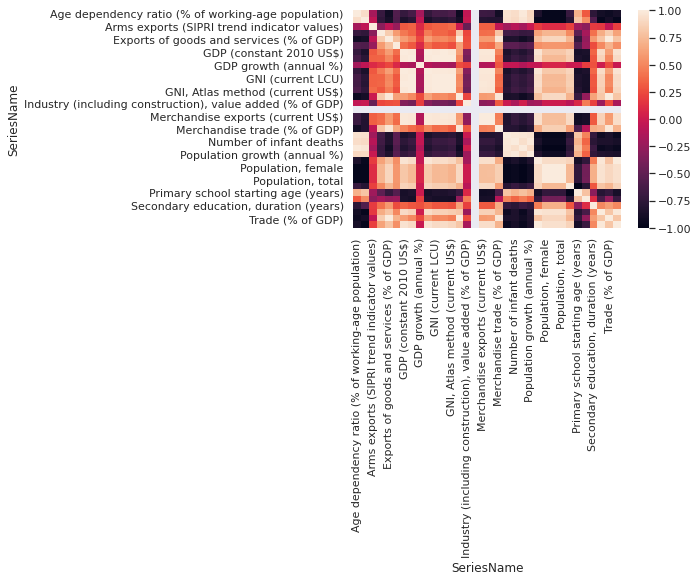

In [32]:
import seaborn as sns; sns.set_theme()
sns.heatmap(df_meas2.corr())